In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from splitkci import dependence_measures
from splitkci import pval_computations

In [27]:
plt.rcParams["svg.fonttype"] = 'none'

In [28]:
results_location = os.path.join(os.environ['SCRATCH'], 'splitkci_testing_results/budget_experiment')
names = {'kci': 'KCI', 'kci_asplit': 'SplitKCI', 'circe': 'CIRCE', 'gcm': 'GCM', 'rbpt2_ub': 'RBPT2\'',
            'rbpt2': 'RBPT2', 'kci_absplit': 'SplitKCI-2', 'circe_bsplit': 'SplitCIRCE'}
colors = {'kci': '#0072B2', 'kci_asplit': '#009E73',
          'circe': '#821651', 'gcm': '#E69F00', 
          'rbpt2_ub': '#D55E00', 'rbpt2': '#000000', 'kci_absplit': '#000000',
          'circe_bsplit': '#808080'}

In [29]:
def add_se_plot(x, y, ax, label, color, mult=1):
    ax.plot(x, y.mean(axis=1), label=label, color=color)
    ax.fill_between(x, y.mean(axis=1) - mult * y.std(axis=1) / np.sqrt(y.shape[1]),
                    y.mean(axis=1) + mult * y.std(axis=1) / np.sqrt(y.shape[1]),
                    alpha=0.5, color=color)

In [30]:
def load_data(measure, budget, ground_truth):
    ratio_grid = np.linspace(0.1, 0.8, 8)
    
    pval = torch.zeros((len(ratio_grid), 100))  
    loo_ca = torch.zeros((len(ratio_grid), 100, 2 if 'asplit' in measure or 'absplit' in measure else 1))  
    loo_cb = torch.zeros((len(ratio_grid), 100, 2 if 'absplit' in measure else 1))  
    K_aa_list = list()
    K_bb_list = list()
    K_cc_list = list()

    for ratio_idx, ratio in enumerate(ratio_grid):
        exp_name = f'budget_{measure}_all_{budget}_{ground_truth}seeds0_100_d100_r{ratio:.2f}.pt'
        exp_data = torch.load(os.path.join(results_location, exp_name),
                              map_location=torch.device('cpu'))

        pval[ratio_idx] = exp_data['pval']
        loo_ca[ratio_idx] = exp_data['loo_ca']
        loo_cb[ratio_idx] = exp_data['loo_cb']
        K_aa_list.append(exp_data['Kaa_list'])
        K_bb_list.append(exp_data['Kbb_list'])
        K_cc_list.append(exp_data['Kcc_list'])
    return ratio_grid, pval, loo_ca, loo_cb, K_aa_list, K_bb_list, K_cc_list

In [31]:
def compute_pval(stat, K, L):
    return pval_computations.compute_wild_bootstrap_pval(
                    stat, K=K, L=L,
                    return_params=False, n_samples=100,
                    compute_stat_func=lambda x, y: dependence_measures.compute_hsic(x, y, False),
                    chunk_size=100)

In [32]:
# for budget in [200, 500, 1000]:
#     alpha = 0.05

#     all_data = {'kci': {'H0': dict(), 'H1': dict()}, 
#                 'kci_asplit': {'H0': dict(), 'H1': dict()},
#                 'kci_absplit': {'H0': dict(), 'H1': dict()}}

#     for measure in ['kci', 'kci_asplit', 'kci_absplit']:
#         for g_idx, ground_truth in enumerate(['H0', 'H1']):
#             ratio_grid, pval, loo_ca, loo_cb, K_aa_list, K_bb_list, K_cc_list = \
#                 load_data(measure, budget, ground_truth)

#             if ground_truth == 'H0':
#                 error = (pval <= alpha).float()
#             else:
#                 error = 1 - (pval <= alpha).float()

#             for new_var in ['ratio_grid', 'pval', 'loo_ca', 'loo_cb', 'error']:
#                 all_data[measure][ground_truth][new_var] = eval(new_var)

#             all_data[measure][ground_truth]['kci_ac'] = np.zeros((len(K_aa_list), len(K_aa_list[0])))
#             all_data[measure][ground_truth]['kci_bc'] = np.zeros((len(K_aa_list), len(K_aa_list[0])))
#             all_data[measure][ground_truth]['kci_ac_pval'] = np.zeros((len(K_aa_list), len(K_aa_list[0])))
#             all_data[measure][ground_truth]['kci_bc_pval'] = np.zeros((len(K_aa_list), len(K_aa_list[0])))

#             for i in range(all_data[measure][ground_truth]['kci_ac'].shape[0]):
#                 for j in range(all_data[measure][ground_truth]['kci_ac'].shape[1]):
#                     all_data[measure][ground_truth]['kci_ac'][i, j] = dependence_measures.compute_hsic(K_aa_list[i][j],
#                                                                                  K_cc_list[i][j] ** 2,
#                                                                                  biased=False) #+ \
#                     all_data[measure][ground_truth]['kci_ac_pval'][i, j] = compute_pval(
#                         all_data[measure][ground_truth]['kci_ac'][i, j],
#                         K_aa_list[i][j], K_cc_list[i][j] ** 2)

#                     all_data[measure][ground_truth]['kci_bc'][i, j] = dependence_measures.compute_hsic(K_bb_list[i][j],
#                                                                              K_cc_list[i][j] ** 2,
#                                                                              biased=False) #+ \
#                     all_data[measure][ground_truth]['kci_bc_pval'][i, j] = compute_pval(
#                         all_data[measure][ground_truth]['kci_bc'][i, j], 
#                         K_bb_list[i][j], K_cc_list[i][j] ** 2)
#     np.save(f'pre_saved_{budget}_UPD.npy', all_data)


In [33]:
all_data = dict()
for budget in [200, 500, 1000]:
    all_data[str(budget)] = np.load(f'pre_saved_{budget}_UPD.npy', allow_pickle=True).item()

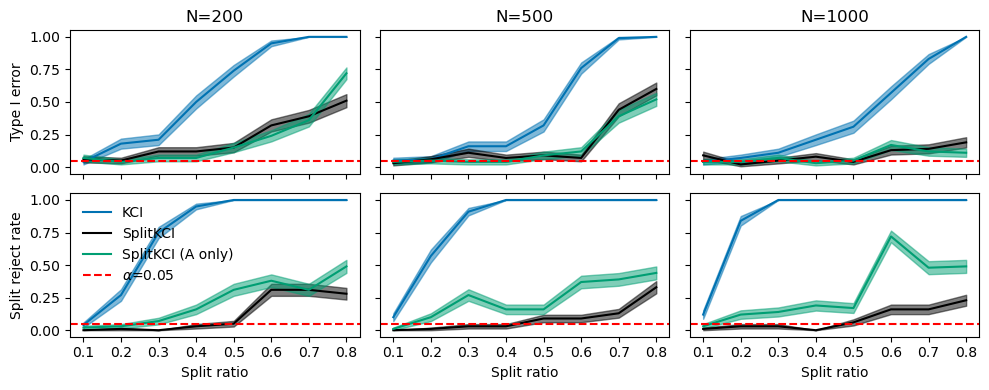

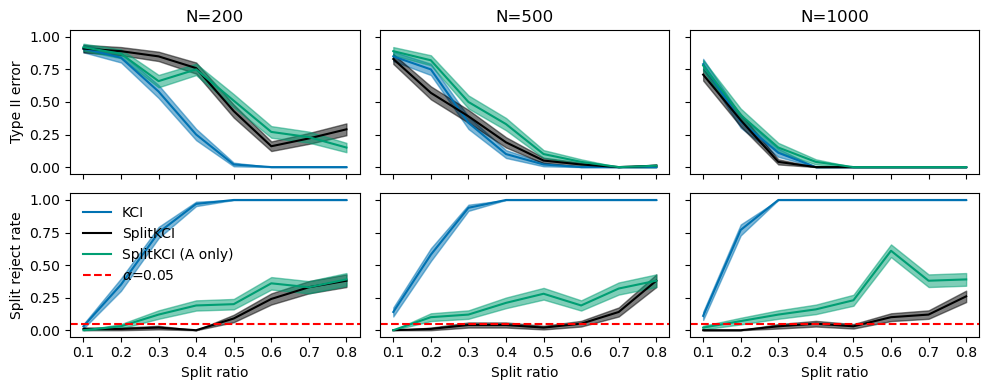

In [35]:
xlabel = {'H0': 'Type I error', 'H1': 'Type II error'}
measure_labels = {'kci': 'KCI', 'kci_asplit': 'SplitKCI (A only)', 'kci_absplit': 'SplitKCI'}

for ground_truth in ['H0', 'H1']:
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharex=True, sharey='row')

    alpha = 0.05
    split_alpha = 0.05
    
    for i, budget in enumerate([200, 500, 1000]):
        ax[0, i].set_title(f'N={budget}')
        for measure in ['kci', 'kci_absplit', 'kci_asplit']:
            ratio_grid = all_data[str(budget)][measure][ground_truth]['ratio_grid']
            error = all_data[str(budget)][measure][ground_truth]['error']
            color = colors[measure]

#             ax[0, i].plot(ratio_grid, error.mean(axis=1), label=measure, color=color)
#             ax[0, i].fill_between(ratio_grid, error.mean(axis=1) - error.std(axis=1) / np.sqrt(error.shape[1]),
#                                       error.mean(axis=1) + error.std(axis=1) / np.sqrt(error.shape[1]), alpha=0.5,
#                                      color=color)
            add_se_plot(ratio_grid, error,
                        ax[0, i], measure_labels[measure], color, 1)
            add_se_plot(ratio_grid, np.logical_and(all_data[str(budget)][measure][ground_truth]['kci_ac_pval'] < split_alpha, 
                                                   all_data[str(budget)][measure][ground_truth]['kci_bc_pval'] < split_alpha),
                        ax[1, i], measure_labels[measure], color, 1)

        if ground_truth == 'H0':
            ax[0, i].axhline(alpha, color='r', linestyle='--', label=r'$\alpha$=0.05')
        ax[1, i].axhline(split_alpha, color='r', linestyle='--', label=r'$\alpha$=0.05')



    ax[1, 0].set_xlabel('Split ratio')
    ax[1, 1].set_xlabel('Split ratio')
    ax[1, 2].set_xlabel('Split ratio')
    ax[0, 0].set_ylabel(xlabel[ground_truth])
    ax[1, 0].set_ylabel('Split reject rate')

#     for each_ax in ax.flatten():
#         each_ax.set_xticks(ratio_grid)
#         each_ax.set_ylim(-0.05, 1.05)
    ax[0, 0].set_xticks(ratio_grid)
    ax[0, 0].set_ylim(-0.05, 1.05)
    ax[1, 0].set_ylim(-0.05, 1.05)
    ax[1, 0].legend(frameon=False)

    plt.tight_layout()
    plt.savefig(f'figs/budget_{ground_truth}.svg', transparent=True)
    plt.show()